# Preliminaries

In [1]:
import numpy as np
import matplotlib.pylab as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors

In [2]:
from dissipationtheory.constants import ureg, qe, epsilon0
from dissipationtheory.dissipation6 import CantileverModel, SampleModel1, SampleModel2
from dissipationtheory.dissipation6 import CantileverModelJit, SampleModel1Jit, SampleModel2Jit
from dissipationtheory.dissipation6 import theta1norm_jit, theta2norm_jit
from dissipationtheory.dissipation6 import gamma_perpendicular_jit, blds_perpendicular_jit
from dissipationtheory.dissipation6 import ExptSweepConductivity

In [3]:
THIS = 'dissipation-theory--Study-42--'
figs = {}

# Set up the cantilever

In [4]:
cantilever = CantileverModel(
    f_c = ureg.Quantity(75, 'kHz'),
    k_c = ureg.Quantity(2.8, 'N/m'), 
    V_ts = ureg.Quantity(1, 'V'), 
    R = ureg.Quantity(35, 'nm'),
    angle = ureg.Quantity(20, 'degrees'),
    d = ureg.Quantity(38, 'nm'),
    z_c = ureg.Quantity(73, 'nm')
)

In [5]:
cantilever

cantilever

         resonance freq = 75.000 kHz
                        = 4.712e+05 rad/s
        spring constant = 2.800 N/m
     tip-sample voltage = 1.000 V
                 radius = 35.000 nm
        cone half angle = 20.000 degree
                 height = 38.000 nm
  tip charge z location = 73.000 nm

# Set up the sample

Assume a fixed mobility of $\mu = 10^{-8} \: \mathrm{m}^2/\mathrm{V s}$, an ionic mobility.  As we vary the conductivity $\sigma$, we should vary the charge density $\rho$ to keep the mobility constant.  Pick a starting $\sigma$ and compute the associated charge density that achieves the above target mobility.

In [6]:
mu = ureg.Quantity(1e-8, 'm^2/(V s)') 
sigma = ureg.Quantity(1E-5, 'S/m')
rho = (sigma / (qe * mu)).to('1/m^3')

Set up the sample object.

In [7]:
sample1 = SampleModel1(
    cantilever = cantilever,
    h_s = ureg.Quantity(7300, 'nm'), # 100 times the sample-charge separation
    epsilon_s = ureg.Quantity(complex(20, -0.2), ''),   # change from 20 to 100
    sigma = sigma,
    rho = rho,
    epsilon_d = ureg.Quantity(complex(1e6, 0), ''),
    z_r = ureg.Quantity(73, 'nm')
)

Print out the sample parameters, making sure the mobility is correct.

In [8]:
sample1

cantilever

         resonance freq = 75.000 kHz
                        = 4.712e+05 rad/s
        spring constant = 2.800 N/m
     tip-sample voltage = 1.000 V
                 radius = 35.000 nm
        cone half angle = 20.000 degree
                 height = 38.000 nm
  tip charge z location = 73.000 nm

semiconductor

             epsilon (real) = 20.000
             epsilon (imag) = -0.200
                  thickness = 7300.0 nm
               conductivity = 1.000e-05 S/m
             charge density = 6.242e+21 m^{-3}
           reference height = 7.300e+01 nm

         roll-off frequency = 1.129e+06 Hz
                   mobility = 1.000e-08 m^2/(V s)
         diffusion constant = 2.585e-10 m^2/s
               Debye length = 1.513e+01 nm
           diffusion length = 2.342e+01 nm
   effective epsilon (real) = 20.000
   effective epsilon (imag) = -2.597

dielectric

  epsilon (real) = 1000000.000
  epsilon (imag) = 0.000
       thickness = infinite

Create the jit sample object.

In [9]:
sample1_jit = SampleModel1Jit(**sample1.args())

# Loop over charge density

I am largely echoing the code from `Study 29` here, but with minor improvements.  Set up an array of modulation frequencies and an array of conductivities.

For code development, set

* `N_omega` = 10
* `N_sigma` = 10

To make paper-quality figures, rerun with

* `N_omega` = 100
* `N_sigma` = 200

In [10]:
N_omega = 10 # 10 or 100
N_sigma = 20 # 20 or 200

In [11]:
omega_m__array = ureg.Quantity(
    np.logspace(
        start=np.log10(1e1),
        stop=np.log10(1e8),
        num=N_omega), 'Hz')

In [12]:
sigma__array = ureg.Quantity(
    np.logspace(
        start=np.log10(1e-10),
        stop=np.log10(1),
        num=N_sigma), 'S/m')

Assume a fixed mobility of $\mu = 10^{-8} \: \mathrm{m}^2/\mathrm{V s}$, an ionic mobility.  As we vary $\sigma$, we should vary the charge density $\rho$ to keep the mobility constant.  Compute a corresponding charge density array.

In [13]:
mu = ureg.Quantity(1e-8, 'm^2/(V s)') 
rho__array = (sigma__array / (qe * mu)).to('1/m^3')

**New** Roger's new expression depends on $\omega_{\mathrm{c}} - \omega_{\mathrm{m}}$, which could go to zero.  The cantilever frequency is

In [14]:
sample1.cantilever.omega_c.to('kHz').magnitude

471.23889803846896

while $\omega_{\mathrm{c}} - \omega_{\mathrm{m}}$ is

In [15]:
(sample1.cantilever.omega_c - omega_m__array).to('kHz').magnitude

array([ 4.71228898e+02,  4.71178950e+02,  4.70879517e+02,  4.69084463e+02,
        4.58323401e+02,  3.93812530e+02,  7.08001468e+00, -2.31132050e+03,
       -1.62097665e+04, -9.95287611e+04])

Or, as we see above, could go negative.

Get ready to run the simuations.

In [16]:
expt = {}        # many simulations
expt['01'] = {}  # the first simulation

Loop over conductivities, computing the BLDS spectrum and the friction.

In [17]:
%%time

expt['01'] = ExptSweepConductivity('perovskite-like sample')
expt['01'].calculate(theta1norm_jit, sample1_jit, omega_m__array, rho__array, sigma__array)

/Users/jam99/Dropbox/MarohnGroup__Software_Library/dissipationtheory/dissipationtheory/dissipation6.py:822: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  integral = integrate.quad(theta, 0., np.inf, args=(sample, omega, power, False))[0]
/Users/jam99/Dropbox/MarohnGroup__Software_Library/dissipationtheory/dissipationtheory/dissipation6.py:822: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  integral = integrate.quad(theta, 0., np.inf, args=(sample, omega, power, False))[0]
/Users/jam99/Dropbox/MarohnGroup__Software_Library/dissipationtheory/dissipationtheory/dissipation6.py:822: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  inte

CPU times: user 501 ms, sys: 9.41 ms, total: 510 ms
Wall time: 593 ms


/Users/jam99/Dropbox/MarohnGroup__Software_Library/dissipationtheory/dissipationtheory/dissipation6.py:822: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  integral = integrate.quad(theta, 0., np.inf, args=(sample, omega, power, False))[0]
/Users/jam99/Dropbox/MarohnGroup__Software_Library/dissipationtheory/dissipationtheory/dissipation6.py:822: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  integral = integrate.quad(theta, 0., np.inf, args=(sample, omega, power, False))[0]
/Users/jam99/Dropbox/MarohnGroup__Software_Library/dissipationtheory/dissipationtheory/dissipation6.py:822: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  inte

Why do we get errors?

# Examine the results

Print out calculation results for the lowest conductivity.

In [18]:
expt['01'].df.iloc[-1]

sigma [S/m]                                                     1.0
rho [1/cm^3]                                624150909004333842432.0
L_D [nm]                                                   0.047843
rho scaled 1                                         2328106.511962
rho scaled 2                                          116405.325598
rho scaled 3                                           15035.562593
omega0 [Hz]                                      112940906737.30191
omega_c [Hz]                                          471238.898038
omega_c scaled                                          11983.40239
omega_m [Hz]      [10.0, 59.94842503189409, 359.38136638046257, ...
omega_m scaled    [1.77083756256e-09, 1.0615892286279022e-08, 6....
f_BLDS [Hz]       [-0.5862980372269911, -0.5862980464513443, -0....
gamma [pN s/m]                                             0.000974
Name: 19, dtype: object

The four columns in the following table are 

- the modulation frequency $\omega_{\mathrm{m}}$ [Hz],
- the offset frequency  $\omega_{-} = \omega_{\mathrm{c}} - \omega_{\mathrm{m}}$ [Hz],
- the BLDS signal $\Delta f_{\mathrm{BLDS}}$ at min conductivity, and 
- the BLDS signal $\Delta f_{\mathrm{BLDS}}$ at max conductivity.

We can see that $\Delta f_{\mathrm{BLDS}}$ diverges as $\omega_{-} = \omega_{\mathrm{c}} - \omega_{\mathrm{m}} \rightarrow 0$ or, equivalently, as $\omega_{\mathrm{m}} \rightarrow \omega_{\mathrm{c}}$.  For negative offset $\omega_{-}$, i.e. $\omega_{\mathrm{m}} > \omega_{\mathrm{c}}$ the integration returns `nan` (not a number).  Conclude that the $K_2$ integral is not happy with a negative frequency.

In [19]:
offset = (sample1.cantilever.omega_c - omega_m__array).to('Hz').magnitude

for a, b, c, d, in zip(
    expt['01'].df.iloc[0]['omega_m [Hz]'],
    offset,
    expt['01'].df.iloc[0]['f_BLDS [Hz]'],
    expt['01'].df.iloc[-1]['f_BLDS [Hz]']):
    
    print('{:11.1f} {:11.1f} {:11.3f} {:11.3f}'.format(a,b,c,d))

       10.0    471228.9      -0.531      -0.586
       59.9    471178.9      -0.531      -0.586
      359.4    470879.5      -0.531      -0.586
     2154.4    469084.5      -0.531      -0.586
    12915.5    458323.4      -0.531      -0.587
    77426.4    393812.5      -0.545      -0.603
   464158.9      7080.0     -17.795     -19.659
  2782559.4  -2311320.5         nan         nan
 16681005.4 -16209766.5         nan         nan
100000000.0 -99528761.1         nan         nan


# Understand the results

In [20]:
from dissipationtheory.dissipation6 import K_jit

The two columns in the following table are

- the offset frequency  $\omega_{-} = \omega_{\mathrm{c}} - \omega_{\mathrm{m}}$ [Hz] and
- the integral $K_2(\omega_{-})$ [$\mu\mathrm{m}^{-3}$].

We can see that $K_2(\omega_{-})$ is well-behaved as $\omega_{-} \rightarrow 0$ but is not well behaved when $\omega_{-} < 0$.

In [21]:
for delta in offset:
    K2 = K_jit(2, theta1norm_jit, sample1_jit, delta, False).to('um^-3').magnitude
    print('{:11.1f} {:15.7f}'.format(delta, K2))

   471228.9     642.3629986
   471178.9     642.3629986
   470879.5     642.3629986
   469084.5     642.3629986
   458323.4     642.3629986
   393812.5     642.3629987
     7080.0     642.3629989
 -2311320.5             nan
-16209766.5             nan
-99528761.1             nan


/Users/jam99/Dropbox/MarohnGroup__Software_Library/dissipationtheory/dissipationtheory/dissipation6.py:822: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  integral = integrate.quad(theta, 0., np.inf, args=(sample, omega, power, False))[0]


$K_2$ at zero frequency diverges.

In [22]:
K_jit(2, theta1norm_jit, sample1_jit, 0., False).to('um^-3').magnitude

ZeroDivisionError: division by zero

$K_2$ at a frequency of $0.0001$ converges.

In [23]:
K_jit(2, theta1norm_jit, sample1_jit, 0.0001, False).to('um^-3').magnitude

642.3629989113796

$K_2$ at negative frequency fails to converge.

In [24]:
K_jit(2, theta1norm_jit, sample1_jit, -0.0001, False).to('um^-3').magnitude

nan

# Plot the integrand

## Sample Model 1

In [25]:
mu = ureg.Quantity(1e-8, 'm^2/(V s)') 
sigma = ureg.Quantity(1E-5, 'S/m')
rho = (sigma / (qe * mu)).to('1/m^3')

sample1 = SampleModel1(
    cantilever = cantilever,
    h_s = ureg.Quantity(7300, 'nm'), # 100 times the sample-charge separation
    epsilon_s = ureg.Quantity(complex(20, -0.2), ''),   # change from 20 to 100
    sigma = sigma,
    rho = rho,
    epsilon_d = ureg.Quantity(complex(1e6, 0), ''),
    z_r = ureg.Quantity(73, 'nm')
)

sample1_jit = SampleModel1Jit(**sample1.args())

The Sample 1 integrand is well behaved at low frequency.

In [26]:
psi = np.logspace(-5,5,100)

In [27]:
omega = 0.001
theta1 = np.array([theta1norm_jit(y, sample1_jit, omega, 2, False) for y in psi])

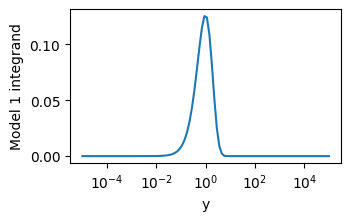

In [28]:
fig = plt.figure(figsize=(3.5,2.0))
plt.semilogx(psi, theta1)
plt.xlabel('y')
plt.ylabel(r'Model 1 integrand')
plt.show()

The Sample 1 integrand returns nonsense at negative frequency.

In [29]:
theta1norm_jit(0., sample1_jit, -0.001, 2, False)

nan

## Sample Model 2

In [30]:
mu = ureg.Quantity(1e-8, 'm^2/(V s)') 
sigma = ureg.Quantity(1E-5, 'S/m')
rho = (sigma / (qe * mu)).to('1/m^3')

sample2 = SampleModel2(
    cantilever = cantilever,
    h_d = ureg.Quantity(0, 'nm'),
    epsilon_d = ureg.Quantity(complex(1, 0), ''),
    epsilon_s = ureg.Quantity(complex(20, -0.2), ''), 
    sigma = sigma,
    rho = rho,
    z_r = ureg.Quantity(73, 'nm')
)

sample2_jit = SampleModel2Jit(**sample2.args())

The Sample 2 integrand is well behaved at low frequency.

In [31]:
omega = 0.001
theta2 = np.array([theta2norm_jit(y, sample2_jit, omega, 2, False) for y in psi])

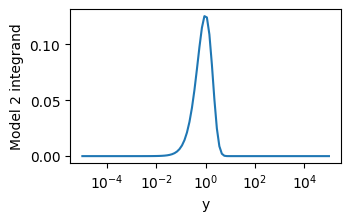

In [32]:
fig = plt.figure(figsize=(3.5,2.0))
plt.semilogx(psi, theta2)
plt.xlabel('y')
plt.ylabel(r'Model 2 integrand')
plt.show()

The Sample 2 integrand returns nonsense at negative frequency.

In [33]:
theta2norm_jit(0., sample2_jit, -0.001, 2, False)

nan

## Model 1 and Model 2 difference

The difference in the two integrands is very very small.

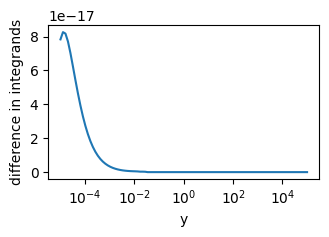

In [35]:
fig = plt.figure(figsize=(3.5,2.0))
plt.semilogx(psi, theta2 - theta1)
plt.xlabel('y')
plt.ylabel('difference in integrands')
plt.show()

# Plot the results

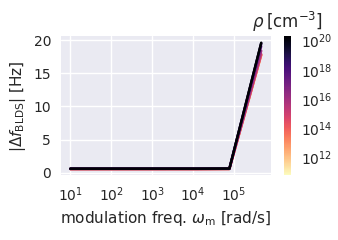

In [45]:
figs['01'] = expt['01'].plot_BLDS(n=2, scaled=False)

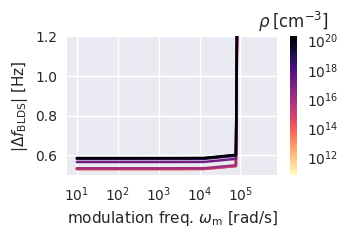

In [46]:
figs['01'].gca().set_ylim([0.5,1.2]);
figs['01']

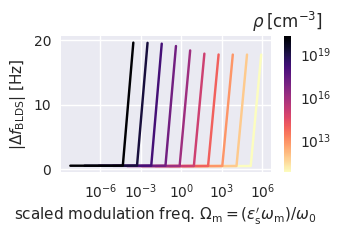

In [47]:
figs['02'] = expt['01'].plot_BLDS(n=2, scaled=True)

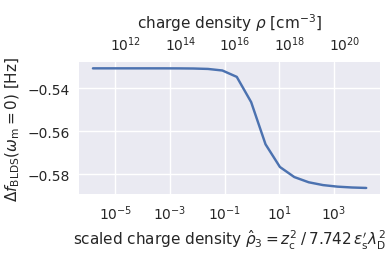

In [43]:
figs['03'] = expt['01'].plot_BLDS_zero()

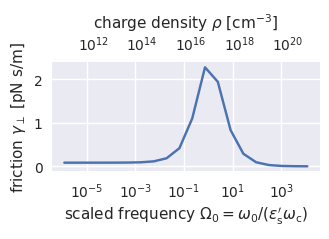

In [42]:
figs['04'] = expt['01'].plot_friction()

::: {.content-hidden when-format="html"}

# Save the figures

In [41]:
if 0:
    for num in figs.keys():
        figname = THIS + "Fig-" + num
        figs[num].savefig(figname + '.png', dpi=300)
        figs[num].savefig(figname + '.pdf')

:::

::: {.content-hidden when-format="html"}

# Formatting notes

The header at the top of this file is for creating a nicely-formatted `.html` document using the program `quarto` ([link](https://quarto.org/)).  To create nicely-formated `.html`versions of this notebook, run `quarto` from the command line as follows

    quarto render dissipation-theory--Study-42.ipynb 

Other useful information about this notebook:

- Filename: `dissipation-theory--Study-42.ipynb`
- Continued from: `dissipation-theory--Study-39.ipynb`
- Continued to: ---

:::